In [1]:
import arviz as az
import matplotlib.pyplot as plt
import pymc as pm
from loguru import logger

In [2]:
def plot_priors_and_posteriors(
    trace: az.InferenceData,
    prior_trace: az.InferenceData,
    posterior_trace: az.InferenceData,
):
    _, axes = plt.subplots(3, 2, figsize=(12, 9))

    axes[0][0].hist(prior_trace.prior["p"].mean("chain"))
    axes[0][1].hist(trace.posterior["p"].mean("chain"))

    axes[0][0].set_title("Prior distribution of $p$")
    axes[0][1].set_title("Posterior distribution of $p$")

    axes[1][0].hist(prior_trace.prior["male : female"].mean("chain"))
    axes[1][1].hist(trace.posterior["male : female"].mean("chain"))

    axes[1][0].set_title(r"Prior distribution of $\phi$")
    axes[1][1].set_title(r"Posterior distribution of $\phi$")

    axes[2][0].hist(prior_trace.prior_predictive["likelihood"].mean("chain"))
    axes[2][1].hist(posterior_trace.posterior_predictive["likelihood"].mean("chain"))

    axes[2][0].set_title("Prior distribution of $y$")
    axes[2][1].set_title("Posterior distribution of $y$")

    plt.tight_layout()
    plt.show()

# Example 2.1 - Estimating the probability of a female birth

## Data

In [3]:
# source: https://www.cdc.gov/nchs/data/vsrr/vsrr012-508.pdf
total_births = 3_605_201
total_females = 1_798_873

print(f"Ratio = {100 * total_females / total_births:.3f}%")

Ratio = 49.897%


## Background

- the currently accepted value of the proportions of female births in large European populations is 0.485.
- $\theta$ = proportion of female births
- $\phi = (1 - \theta) / \theta$ = ratio of male to female birth rates
- $y$ = number of girls in $n$ recorded births
- **goal**: Estimate the sex ratio within a population of human births (like the proportion of female births)

## Theory

**Assumptions:**
- the $n$ births are conditionally independent, given $\theta$; when we have no explanatory information that might affect the sex of the baby (like distinguishing multiple births or births within the same family), the data becomes exchangeable.

## Model 1: Uniform prior

**Model:**
$$
    p(y | \theta) = \text{Bin}(y | n, \theta) = {n \choose k} \theta ^ y (1 - \theta) ^ {n - y}
$$


**Prior:**
$$
p(\theta) = \text{Unif}(0, 1 )
$$

**Posterior:**
$$
\begin{align}
p(\theta | y) & \propto p(\theta) \cdot p(y | \theta) \\
& \propto \theta^y (1 - \theta)^{n - y} \\
\therefore p(\theta | y) = \text{Beta} (y + 1, n - y  + 1)
\end{align}
$$

In [4]:
with pm.Model() as model1:
    # prior
    p = pm.Uniform(name="p", lower=0, upper=1)

    phi = pm.Deterministic("male : female", (1 - p) / p)

    # likelihood
    likelihood = pm.Binomial(
        name="likelihood",
        n=total_births,
        p=p,
        observed=total_females,
    )

    # sample from posterior
    trace1 = pm.sample(2000, tune=1000, progressbar=True)
    logger.info("Finished sampling!")

    prior_trace1 = pm.sample_prior_predictive(1000)
    logger.info("Finished the prior predictive sampling!")

    posterior_trace1 = pm.sample_posterior_predictive(trace=trace1)
    logger.info("Finished the posterior predictive sampling!")

Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [p]


Output()

Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 1 seconds.
2025-05-10 18:23:30.740 | INFO     | __main__:<module>:17 - Finished sampling!
Sampling: [likelihood, p]
2025-05-10 18:23:30.776 | INFO     | __main__:<module>:20 - Finished the prior predictive sampling!
Sampling: [likelihood]


Output()

2025-05-10 18:23:30.903 | INFO     | __main__:<module>:23 - Finished the posterior predictive sampling!


In [5]:
az.summary(trace1)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
p,0.499,0.000,0.498,0.499,0.0,0.0,3436.0,5101.0,1.0
male : female,1.004,0.001,1.002,1.006,0.0,0.0,3436.0,5101.0,1.0


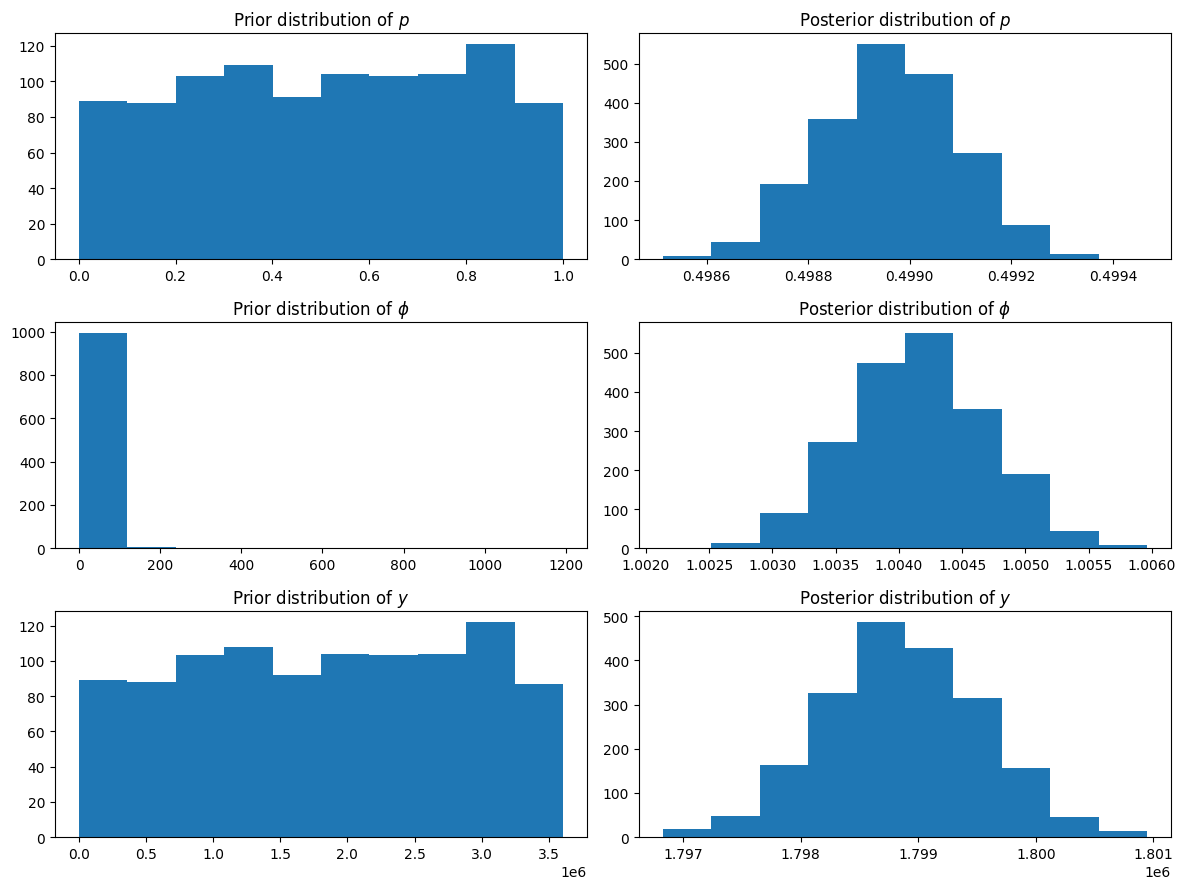

In [6]:
plot_priors_and_posteriors(
    trace=trace1,
    prior_trace=prior_trace1,
    posterior_trace=posterior_trace1,
)

## Model 1: Beta prior

- $p(\theta) = \text{Beta}(\alpha, \beta)$
- $y | \theta = \text{Bin}(n, \theta)$

In [7]:
with pm.Model() as model2:
    # prior
    p = pm.Beta(name="p", alpha=2, beta=6)

    phi = pm.Deterministic("male : female", (1 - p) / p)

    # likelihood
    likelihood = pm.Binomial(
        name="likelihood",
        n=total_births,
        p=p,
        observed=total_females,
    )

    # sample from posterior
    trace2 = pm.sample(2000, tune=1000, progressbar=True)
    logger.info("Finished sampling!")

    prior_trace2 = pm.sample_prior_predictive(1000)
    logger.info("Finished the prior predictive sampling!")

    posterior_trace2 = pm.sample_posterior_predictive(trace=trace2)
    logger.info("Finished the posterior predictive sampling!")

Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [p]


Output()

Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 1 seconds.
2025-05-10 18:23:32.958 | INFO     | __main__:<module>:17 - Finished sampling!
Sampling: [likelihood, p]
2025-05-10 18:23:33.054 | INFO     | __main__:<module>:20 - Finished the prior predictive sampling!
Sampling: [likelihood]


Output()

2025-05-10 18:23:33.188 | INFO     | __main__:<module>:23 - Finished the posterior predictive sampling!


In [8]:
az.summary(trace2)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
p,0.499,0.000,0.498,0.499,0.0,0.0,3258.0,5271.0,1.0
male : female,1.004,0.001,1.002,1.006,0.0,0.0,3258.0,5271.0,1.0


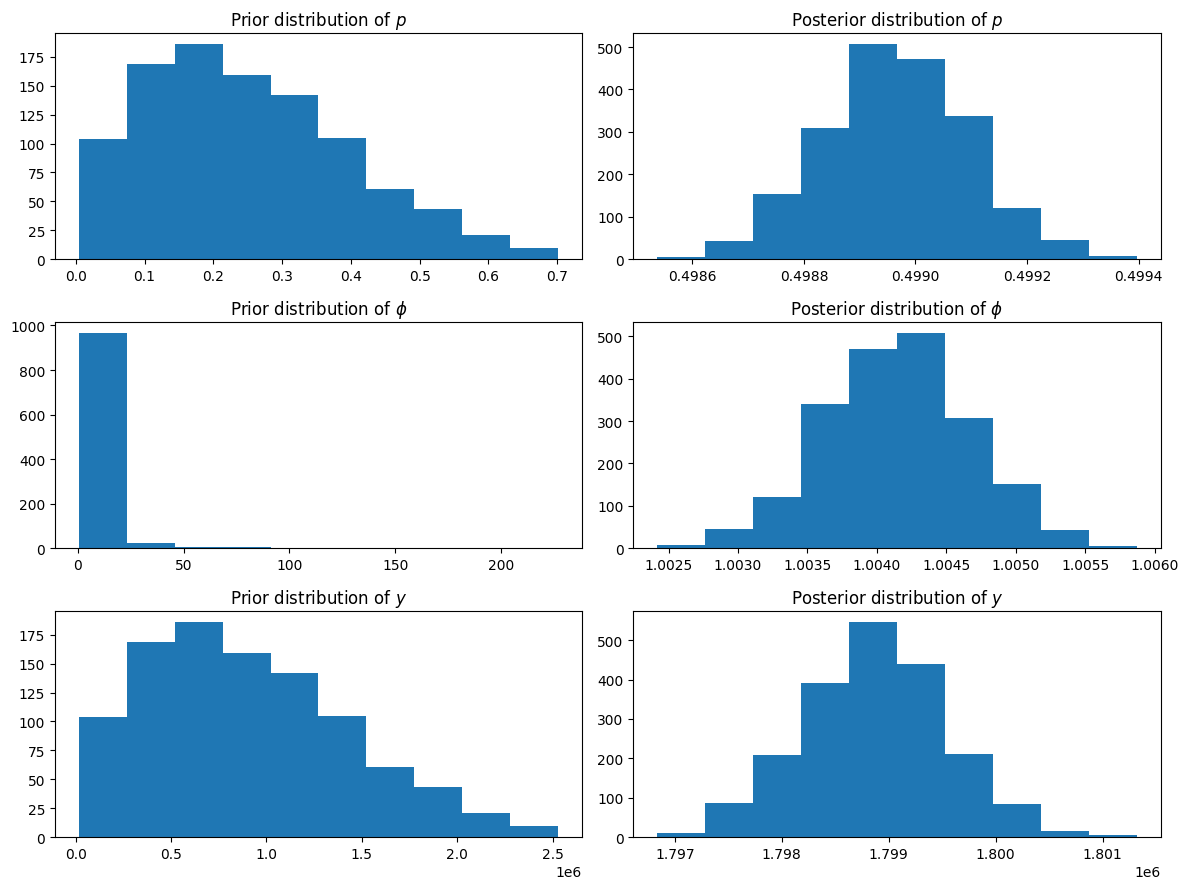

In [9]:
plot_priors_and_posteriors(
    trace=trace2,
    prior_trace=prior_trace2,
    posterior_trace=posterior_trace2,
)

## Model 3: 

- $\mu \sim \text{N}(0, 2)$
- $\theta = \text{logit}^{-1}(\mu) = 1 / (1 + e^{-\mu})$
- $y | \theta = \text{Bin}(n, \theta)$

In [10]:
with pm.Model() as model3:
    # prior
    mu = pm.Normal("mu", mu=0, sigma=2.0)
    p = pm.Deterministic("p", pm.math.invlogit(mu))
    phi = pm.Deterministic("male : female", (1 - p) / p)

    # likelihood
    likelihood = pm.Binomial(
        name="likelihood",
        n=total_births,
        p=p,
        observed=total_females,
    )

    # sample from posterior
    trace3 = pm.sample(2000, tune=1000, progressbar=True)
    logger.info("Finished sampling!")

    prior_trace3 = pm.sample_prior_predictive(1000)
    logger.info("Finished the prior predictive sampling!")

    posterior_trace3 = pm.sample_posterior_predictive(trace=trace3)
    logger.info("Finished the posterior predictive sampling!")

Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [mu]


Output()

Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 1 seconds.
2025-05-10 18:23:35.343 | INFO     | __main__:<module>:17 - Finished sampling!
Sampling: [likelihood, mu]
2025-05-10 18:23:35.381 | INFO     | __main__:<module>:20 - Finished the prior predictive sampling!
Sampling: [likelihood]


Output()

2025-05-10 18:23:35.538 | INFO     | __main__:<module>:23 - Finished the posterior predictive sampling!


In [11]:
az.summary(trace3)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
mu,-0.004,0.001,-0.006,-0.002,0.0,0.0,3509.0,5673.0,1.0
p,0.499,0.000,0.498,0.499,0.0,0.0,3509.0,5673.0,1.0
male : female,1.004,0.001,1.002,1.006,0.0,0.0,3509.0,5673.0,1.0


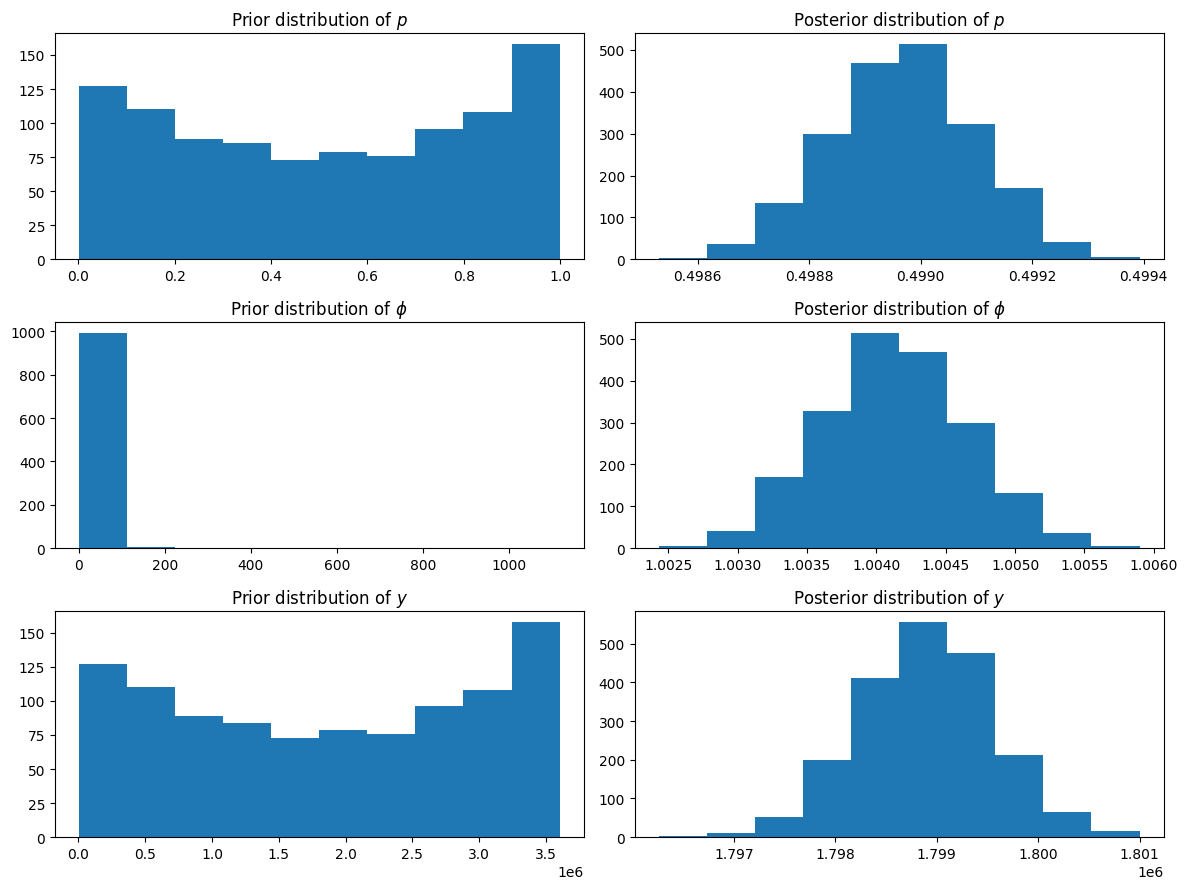

In [12]:
plot_priors_and_posteriors(
    trace=trace3,
    prior_trace=prior_trace3,
    posterior_trace=posterior_trace3,
)